In [1]:
from nanodrt.drt_solver.drt import DRT
from nanodrt.drt_solver.measurements import ImpedenceMeasurement
from nanodrt.drt_solver.simulaton import Simulation
import jax.numpy as jnp 
import pandas as pd

from nanodrt.fitting.optimizer import Optimizer
import matplotlib.pyplot as plt

from nanodrt.drt_solver.utils import (ZARC, 
                                 gamma_ZARC)

In [ ]:
columns = ["f", "Z_re", "Z_im"]
df = pd.read_csv("/Users/tara/Downloads/1_15ml_100mM_DHPS_10_PEIS_C01_EIS_data.csv", header=None, names=columns)

f = jnp.array(df["f"].values)

tau = 1./(2*jnp.pi*f)
#tau = jnp.flip(jnp.logspace(-4, 4, 500))
print(tau)

Z_exact_re =  jnp.array(df["Z_re"].values)
Z_exact_im =  jnp.array(df["Z_im"].values)

# Create our measurement object
measurement = ImpedenceMeasurement(Z_exact_re, Z_exact_im, f)

[6.32255186e-06 7.95966711e-06 1.00251795e-05 1.26218448e-05
 1.58824870e-05 1.99949357e-05 2.51675367e-05 3.16940296e-05
 3.99267492e-05 5.02548050e-05 6.32620302e-05 7.96538778e-05
 1.00252546e-04 1.26273003e-04 1.58900309e-04 2.00130780e-04
 2.51899328e-04 3.16985701e-04 3.99287936e-04 5.02505177e-04
 6.33156617e-04 7.96538790e-04 1.00331258e-03 1.26305340e-03
 1.58900309e-03 2.00153273e-03 2.51983914e-03 3.17393172e-03
 3.99287944e-03 5.02505189e-03 6.33156617e-03 7.96538760e-03
 1.00365238e-02 1.26305346e-02 1.59104021e-02 2.00051358e-02
 2.52203266e-02 3.17393160e-02 3.99287930e-02 5.02776850e-02
 6.33156653e-02 7.96946060e-02 1.00433145e-01 1.26346105e-01
 1.59144793e-01 2.00336653e-01 2.52121800e-01 3.17556105e-01
 4.00143541e-01 5.03347294e-01 6.33645450e-01 7.98412985e-01
 1.00433145e+00 1.26407222e+00 1.59307699e+00]


First we upload our fake dataset that we wish to fit to

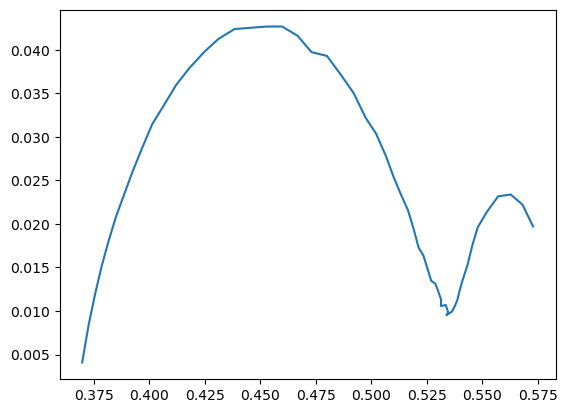

In [ ]:
plt.plot(Z_exact_re, -Z_exact_im)
plt.show()

Next we create our initial guess for the DRT - here we assume a Guassian profile 

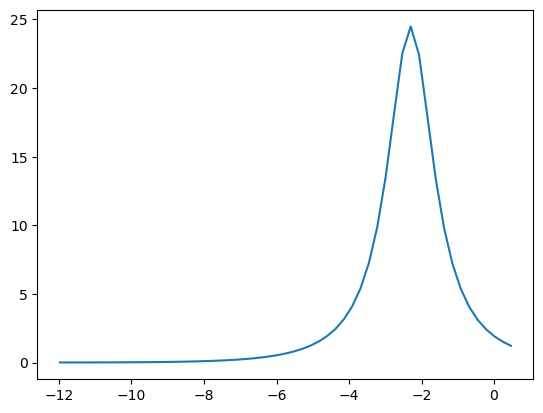

In [ ]:
gamma_guess = gamma_ZARC(tau, R_ct=50, tau_0=.1, phi= .8)
plt.plot(jnp.log(tau), gamma_guess)

In [ ]:
drt = DRT(R_inf= 10, L_0=0, gamma=gamma_guess, tau=tau)

In [ ]:
simulation = Simulation(drt=drt, f_vec=f, integration_method='rbf')
simulation2 = Simulation(drt=drt, f_vec=f, integration_method='trapezoid')

In [ ]:
def normalize_array(arr: jnp.ndarray) -> jnp.ndarray:
    """
    Normalizes the input array so that its values lie between 0 and 1.

    Parameters:
    arr (jnp.ndarray): Input array to be normalized.

    Returns:
    jnp.ndarray: Normalized array with values between 0 and 1.
    """
    min_val = jnp.min(arr)
    max_val = jnp.max(arr)
    normalized = (arr - min_val) / (max_val - min_val)
    return normalized

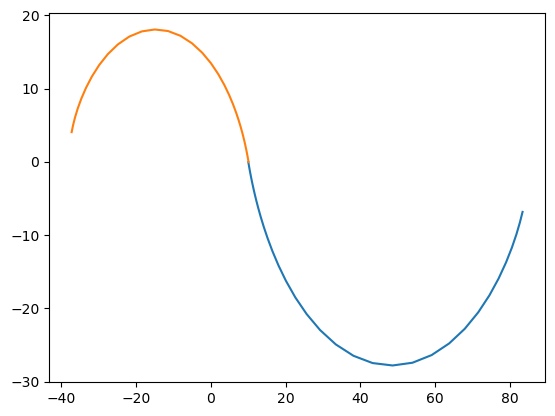

In [ ]:
Z_re_fake, Z_im_fake = simulation.run()
Z_re_fake2, Z_im_fake2 = simulation2.run()


plt.plot((Z_re_fake), (Z_im_fake), )
plt.plot((Z_re_fake2), (Z_im_fake2), )
plt.show()

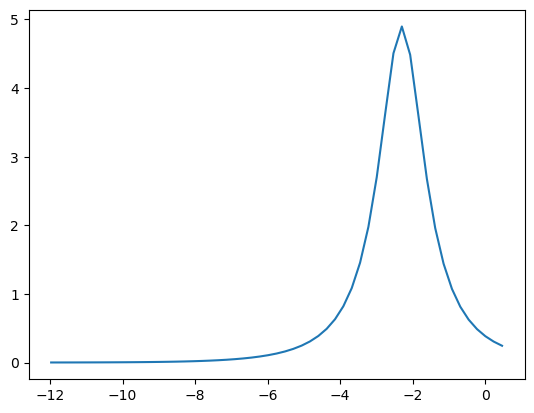

In [ ]:
# Creating Fake Data
# measurement = Measurement(Z_re_fake, Z_im_fake, f)

gamma_guess2 = gamma_ZARC(tau,  R_ct=10, tau_0=.1, phi= .8)
plt.plot(jnp.log(tau), gamma_guess2)

drt_guess = DRT(R_inf=50, L_0=0, gamma=gamma_guess2, tau=tau)

In [ ]:


solver_dict = {'lambda': .1, 'maxiter': 5000000}
optim = Optimizer(drt=drt_guess, measurement=measurement, solver="regression", integration_method="rbf", solver_dict = solver_dict)
final_sim = optim.run()

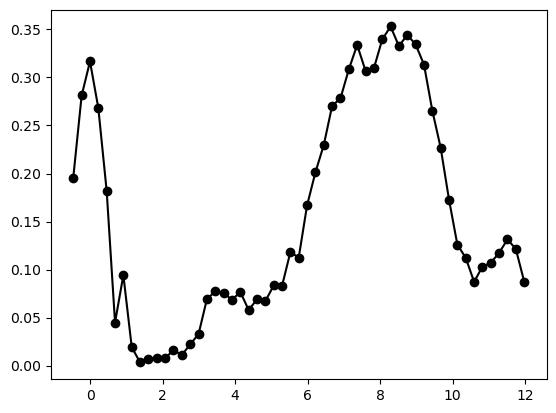

In [ ]:
from jax import vmap 
drt_final = DRT(final_sim.R_inf, final_sim.L_0, final_sim.gamma, final_sim.tau)

# Create simulation object with optimized values
simulation_final = Simulation(drt_final, f_vec=f, integration_method='rbf')


def gaussian(log_tau_m, log_tau_vec, mu) -> float:
    return jnp.exp(-((mu * (log_tau_m - log_tau_vec)) ** 2))

phis = vmap(gaussian, in_axes=(0, None, None))(jnp.log(final_sim.tau), jnp.log(final_sim.tau), 0.5)


plt.plot(jnp.log(1/(final_sim.tau)), (final_sim.gamma.reshape(-1, 1)*phis).sum(axis=-1), 'k-o') # How to plot DRT?
# plt.plot(jnp.log(final_sim.tau), gamma_guess2)
plt.show()


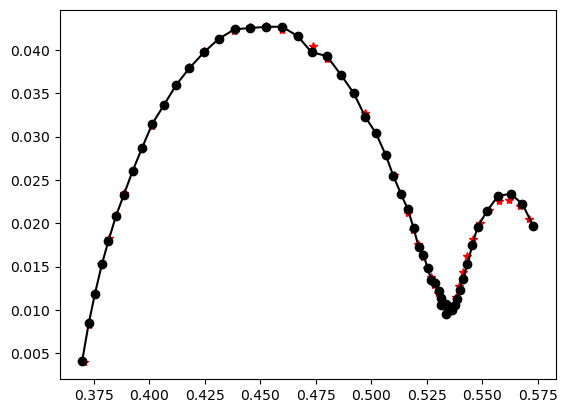

In [ ]:
Z_re, Z_im = simulation_final.run()

plt.plot(Z_re, -Z_im, 'r*')
plt.plot(Z_exact_re, -Z_exact_im, '-ko')
plt.show()

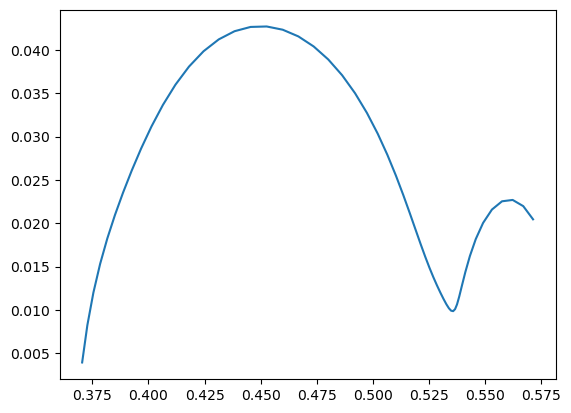

In [ ]:
Z_re, Z_im = final_sim.simulate()
plt.plot(Z_re, -Z_im)